In [ ]:
# Library
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime

import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from v2 import model_t_1, model_t_2, model_t_3, model_t_4, model_t_5, model_t_6, model_t_7, model_t_8
from v2 import model_z_1, model_z_2, model_z_3, model_z_4, model_z_5, model_z_6, model_z_7, model_z_8
from v2 import model_tz_1, model_tz_2, model_tz_3, model_tz_4, model_tz_5, model_tz_6, model_tz_7, model_tz_8

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()


def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
    
def plot_model(model_number, title, data):
    idata = globals()[f"idata_{model_number}"]
    if "sigma_eta" in idata.posterior.data_vars:
        z_mean = globals()[f"z_mean_{model_number}"]
    else:
        z_mean = np.zeros(len(data["DATE"]))
    if "sigma_kappa" in idata.posterior.data_vars:
        kappa_mean = globals()[f"kappa_mean_{model_number}"]
    else:
        kappa_mean = float(idata.posterior["kappa"].mean(dim=["chain", "draw"]))

    alpha_mean = float(idata.posterior["alpha"].mean(dim=["chain", "draw"])) if "alpha" in idata.posterior.data_vars else 0
    beta_mean  = float(idata.posterior["beta"].mean(dim=["chain", "draw"]))
    pi_pred = alpha_mean * data["pi_prev"] + beta_mean * data["Epi"] + kappa_mean * data["Y"] - z_mean
    plt.figure(figsize=(8, 4))
    plt.plot(data["DATE"], pi_pred, label="prediction", color="blue")
    plt.plot(data["DATE"], data["pi"], label="observation", color="red")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("pi_t")
    plt.legend()
    plt.grid(True)
    plt.show()


/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Real data
### Frequency
Quarterly (1982Q1-2024Q3)
### Output gap
Beveridge-Nelson Filter's cycle component (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### The number of Firm
ECNSVY Business Dynamics Statistics (https://data.census.gov/table/BDSTIMESERIES.BDSGEO?q=Bussiness+dynamics+statistics)

---

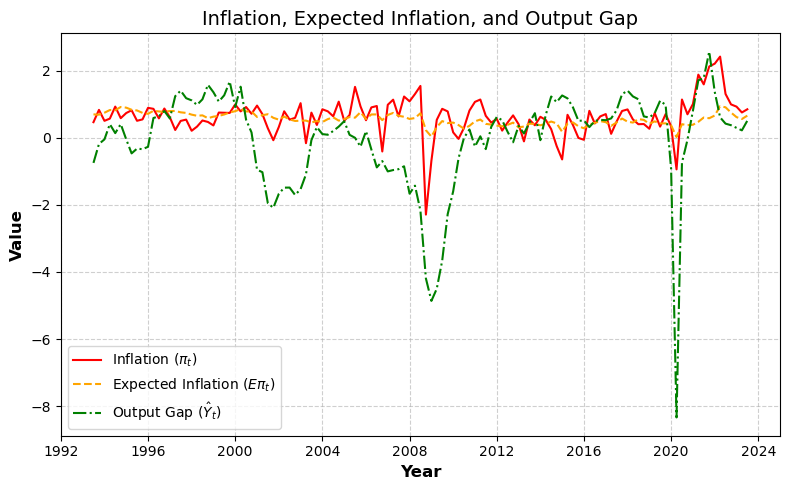

In [3]:
# Data cleaning and plot
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]


data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"]
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"]
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_N = pd.merge(data_Nb, data_Nd, on = "DATE")
data_N = data_N.dropna()
data_N["N"] = data_N["Nb"] - data_N["Nd"]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])
data_N['DATE'] = pd.to_datetime(data_N['DATE'])

data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data["N_prev"] = data["N"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])
n_prev = jnp.array(data['N_prev'])

# plot
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [4]:
warmup= 10000
samples=15000
chains = 2
rng_key = jax.random.PRNGKey(0)

## time-variant $\kappa$ ($z_{t-1} + \kappa_{t-1}$)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
\hat{z}_t = \gamma \hat{z}_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{z} \hat{z}_{{t-1}} + \rho_{\kappa} \kappa_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$
- Note: $\alpha$ + $\beta$ = 1
- Models' state equation
    - Model 9,10:  $\quad \hat{z}_t = \theta_z \hat{z}_{{t-1}} + \eta_t$
    - Model 11,12:  $\quad \hat{z}_t = \theta_Y \hat{Y}_{{t-1}} + \eta_t$
    - Model 13,14:  $\quad \hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_Y \hat{Y}_{{t-1}} + \eta_t$  
    - Model 15,16:  $\quad \hat{z}_t = \theta_z \hat{z}_{{t-1}} + \theta_\pi \pi_{{t-1}} + \theta_Y \hat{Y}_{{t-1}} + \eta_t$ 

In [ ]:
# Model 1
print("Estimating Model 9...")
kernel = NUTS(model_tz_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_9 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()
# z
z_9_samples = posterior_samples["z"]
z_mean_9 = np.mean(z_9_samples, axis=0)
z_std_9 = np.std(z_9_samples, axis=0)
z_lower_9 = z_mean_9 - 1.96 * z_std_9
z_upper_9 = z_mean_9 + 1.96 * z_std_9

# kappa
kappa_9_samples = posterior_samples["kappa"]
kappa_mean_9 = np.mean(kappa_9_samples, axis=0)
kappa_std_9 = np.std(kappa_9_samples, axis=0)
kappa_lower_9 = kappa_mean_9 - 1.96 * kappa_std_9
kappa_upper_9 = kappa_mean_9 + 1.96 * kappa_std_9
model_9_beta  = posterior_samples["beta"].mean()
model_9_theta_z = posterior_samples["theta_z"].mean()
model_9_rho_k = posterior_samples["rho_k"].mean()

# Model 2
print("Estimating Model 10...")
kernel = NUTS(model_tz_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_10 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_10_samples = posterior_samples["z"]
z_mean_10 = np.mean(z_10_samples, axis=0)
z_std_10 = np.std(z_10_samples, axis=0)
z_lower_10 = z_mean_10 - 1.96 * z_std_10
z_upper_10 = z_mean_10 + 1.96 * z_std_10

kappa_10_samples = posterior_samples["kappa"]
kappa_mean_10 = np.mean(kappa_10_samples, axis=0)
kappa_std_10 = np.std(kappa_10_samples, axis=0)
kappa_lower_10 = kappa_mean_10 - 1.96 * kappa_std_10
kappa_upper_10 = kappa_mean_10 + 1.96 * kappa_std_10

model_10_alpha = posterior_samples["alpha"].mean()
model_10_beta  = posterior_samples["beta"].mean()
model_10_theta_z = posterior_samples["theta_z"].mean()
model_10_rho_k = posterior_samples["rho_k"].mean()

# Model 3
print("Estimating Model 11...")
kernel = NUTS(model_tz_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_11 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_11_samples = posterior_samples["z"]
z_mean_11 = np.mean(z_11_samples, axis=0)
z_std_11 = np.std(z_11_samples, axis=0)
z_lower_11 = z_mean_11 - 1.96 * z_std_11
z_upper_11 = z_mean_11 + 1.96 * z_std_11

kappa_11_samples = posterior_samples["kappa"]
kappa_mean_11 = np.mean(kappa_11_samples, axis=0)
kappa_std_11 = np.std(kappa_11_samples, axis=0)
kappa_lower_11 = kappa_mean_11 - 1.96 * kappa_std_11
kappa_upper_11 = kappa_mean_11 + 1.96 * kappa_std_11

model_11_beta  = posterior_samples["beta"].mean()
model_11_theta_z = posterior_samples["theta_z"].mean()
model_11_theta_Y   = posterior_samples["theta_Y"].mean()
model_11_rho_k = posterior_samples["rho_k"].mean()

# Model 4
print("Estimating Model 12...")
kernel = NUTS(model_tz_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_12 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_12_samples = posterior_samples["z"]
z_mean_12 = np.mean(z_12_samples, axis=0)
z_std_12 = np.std(z_12_samples, axis=0)
z_lower_12 = z_mean_12 - 1.96 * z_std_12
z_upper_12 = z_mean_12 + 1.96 * z_std_12

kappa_12_samples = posterior_samples["kappa"]
kappa_mean_12 = np.mean(kappa_12_samples, axis=0)
kappa_std_12 = np.std(kappa_12_samples, axis=0)
kappa_lower_12 = kappa_mean_12 - 1.96 * kappa_std_12
kappa_upper_12 = kappa_mean_12 + 1.96 * kappa_std_12

model_12_alpha = posterior_samples["alpha"].mean()
model_12_beta  = posterior_samples["beta"].mean()
model_12_theta_Y   = posterior_samples["theta_Y"].mean()
model_12_theta_z = posterior_samples["theta_z"].mean()
model_12_rho_k = posterior_samples["rho_k"].mean()


# Model 5
print("Estimating Model 13...")
kernel = NUTS(model_tz_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_13 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_13_samples = posterior_samples["z"]
z_mean_13 = np.mean(z_13_samples, axis=0)
z_std_13 = np.std(z_13_samples, axis=0)
z_lower_13 = z_mean_13 - 1.96 * z_std_13
z_upper_13 = z_mean_13 + 1.96 * z_std_13

kappa_13_samples = posterior_samples["kappa"]
kappa_mean_13 = np.mean(kappa_13_samples, axis=0)
kappa_std_13 = np.std(kappa_13_samples, axis=0)
kappa_lower_13 = kappa_mean_13 - 1.96 * kappa_std_13
kappa_upper_13 = kappa_mean_13 + 1.96 * kappa_std_13

model_13_beta  = posterior_samples["beta"].mean()
model_13_theta_z = posterior_samples["theta_z"].mean()
model_13_theta_Y   = posterior_samples["theta_Y"].mean()
model_13_rho_k = posterior_samples["rho_k"].mean()

# Model 6
print("Estimating Model 14...")
kernel = NUTS(model_tz_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_14 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_14_samples = posterior_samples["z"]
z_mean_14 = np.mean(z_14_samples, axis=0)
z_std_14 = np.std(z_14_samples, axis=0)
z_lower_14 = z_mean_14 - 1.96 * z_std_14
z_upper_14 = z_mean_14 + 1.96 * z_std_14

kappa_14_samples = posterior_samples["kappa"]
kappa_mean_14 = np.mean(kappa_14_samples, axis=0)
kappa_std_14 = np.std(kappa_14_samples, axis=0)
kappa_lower_14 = kappa_mean_14 - 1.96 * kappa_std_14
kappa_upper_14 = kappa_mean_14 + 1.96 * kappa_std_14

model_14_alpha = posterior_samples["alpha"].mean()
model_14_beta  = posterior_samples["beta"].mean()
model_14_theta_z = posterior_samples["theta_z"].mean()
model_14_theta_Y   = posterior_samples["theta_Y"].mean()
model_14_rho_k = posterior_samples["rho_k"].mean()

# Model 7
print("Estimating Model 15...")
kernel = NUTS(model_tz_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_15 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_15_samples = posterior_samples["z"]
z_mean_15 = np.mean(z_15_samples, axis=0)
z_std_15 = np.std(z_15_samples, axis=0)
z_lower_15 = z_mean_15 - 1.96 * z_std_15
z_upper_15 = z_mean_15 + 1.96 * z_std_15

kappa_15_samples = posterior_samples["kappa"]
kappa_mean_15 = np.mean(kappa_15_samples, axis=0)
kappa_std_15 = np.std(kappa_15_samples, axis=0)
kappa_lower_15 = kappa_mean_15 - 1.96 * kappa_std_15
kappa_upper_15 = kappa_mean_15 + 1.96 * kappa_std_15

model_15_beta  = posterior_samples["beta"].mean()
model_15_theta_z = posterior_samples["theta_z"].mean()
model_15_theta_pi = posterior_samples["theta_pi"].mean()
model_15_theta_Y   = posterior_samples["theta_Y"].mean()
model_15_rho_k = posterior_samples["rho_k"].mean()

# Model 8
print("Estimating Model 16...")
kernel = NUTS(model_tz_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_16 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_16_samples = posterior_samples["z"]
z_mean_16 = np.mean(z_16_samples, axis=0)
z_std_16 = np.std(z_16_samples, axis=0)
z_lower_16 = z_mean_16 - 1.96 * z_std_16
z_upper_16 = z_mean_16 + 1.96 * z_std_16

kappa_16_samples = posterior_samples["kappa"]
kappa_mean_16 = np.mean(kappa_16_samples, axis=0)
kappa_std_16 = np.std(kappa_16_samples, axis=0)
kappa_lower_16 = kappa_mean_16 - 1.96 * kappa_std_16
kappa_upper_16 = kappa_mean_16 + 1.96 * kappa_std_16

model_16_alpha = posterior_samples["alpha"].mean()
model_16_beta  = posterior_samples["beta"].mean()
model_16_theta_z = posterior_samples["theta_z"].mean()
model_16_theta_Y   = posterior_samples["theta_Y"].mean()
model_16_theta_pi = posterior_samples["theta_pi"].mean()
model_16_rho_k = posterior_samples["rho_k"].mean()

dict_idata = {'Model-9':idata_9, 'Model-10':idata_10, 'Model-11':idata_11, 'Model-12':idata_12, 
              'Model-13':idata_13,'Model-14':idata_14, 'Model-15':idata_15,'Model-16':idata_16}

params = ["alpha","beta", "theta_z", "theta_Y", "theta_pi", "rho_k"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = f"{summary.loc[param, 'mean']:.3f}"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
summary_df

Estimating Model 9...
Estimating Model 10...
Estimating Model 11...
Estimating Model 12...
Estimating Model 13...
Estimating Model 14...
Estimating Model 15...
Estimating Model 16...


## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

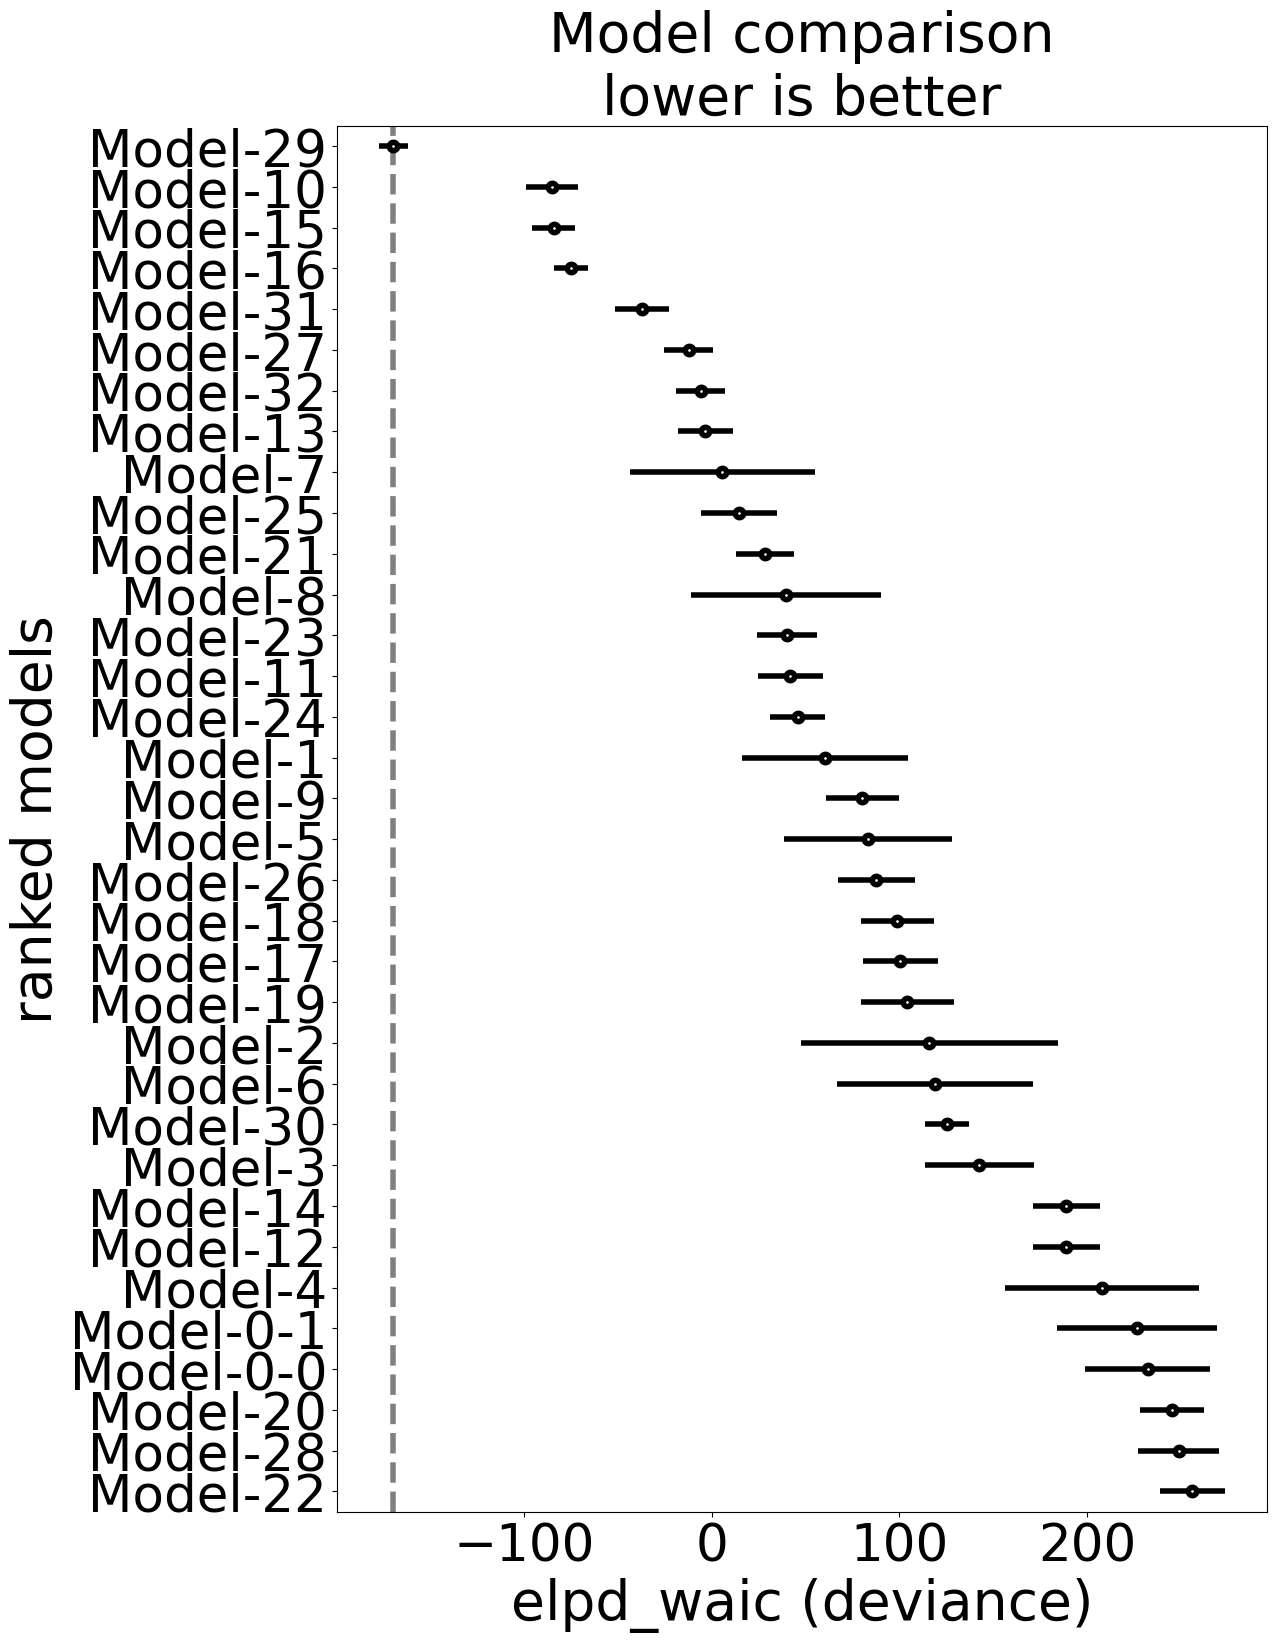

In [ ]:
dict_idata = {
              'Model-9':idata_9, 'Model-10':idata_10, 
              'Model-11':idata_11, 'Model-12':idata_12, 
              'Model-13':idata_13,'Model-14':idata_14,
              'Model-15':idata_15,'Model-16':idata_16,
              }
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(12, 8))

In [11]:
params = ["alpha", "beta", "kappa", "theta_z", "theta_Y", "theta_n", "rho_z"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = f"{summary.loc[param, 'mean']:.3f}"
        else:
            row[param] = "-"
    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.1).sum()
    row["bad params(rhat>1.05)"] = n_bad_rhat
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

latex_code = summary_df.to_latex(index=False)
# display(Markdown(f"```latex\n{latex_code}\n```"))

,model,alpha,beta,kappa,theta_z,theta_Y,theta_n,rho_z,bad params(rhat>1.05)
0,Model-33,-,0.959,0.135,0.466,-,0.001,-,0
1,Model-34,0.063,0.937,0.126,0.388,-,0.001,-,0
2,Model-35,-,0.973,0.147,-,0.064,0.001,-,0
3,Model-36,0.308,0.692,0.164,-,0.105,0.001,-,0
4,Model-37,-,0.960,0.154,0.422,0.043,0.001,-,0
5,Model-38,0.109,0.891,0.158,0.310,0.062,0.001,-,0
6,Model-739,-,0.961,0.154,0.452,0.045,0.001,-,30
7,Model-40,0.122,0.878,0.157,0.334,0.057,0.001,-,0


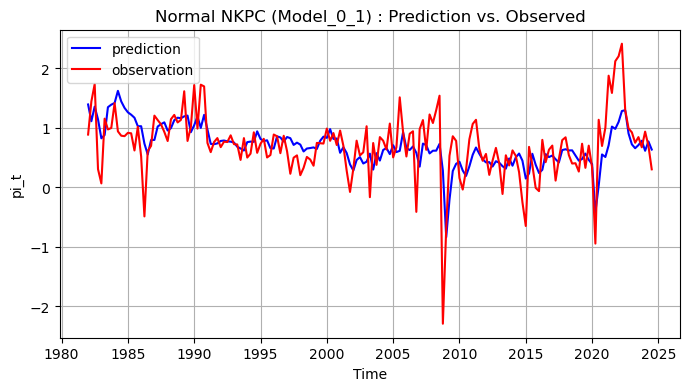

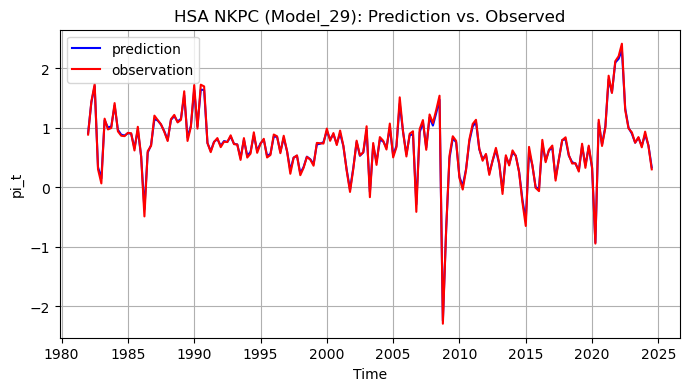

In [ ]:
# Prediction Plot
plot_model("16",   "HSA NKPC (Model_16): Prediction vs. Observed", data)


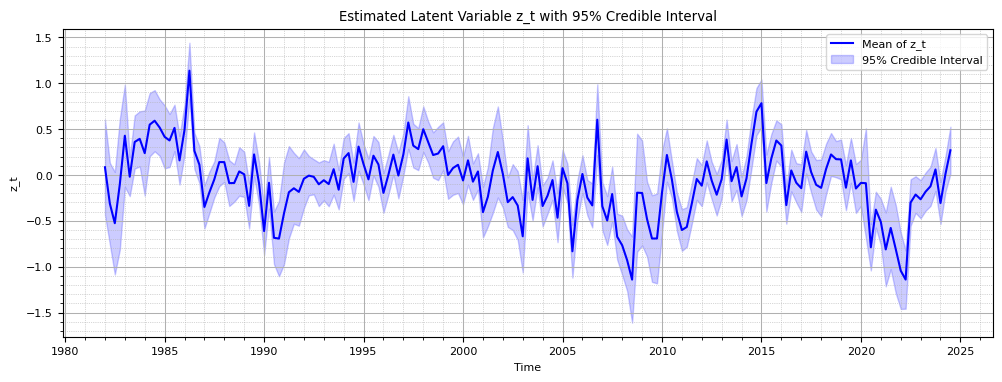

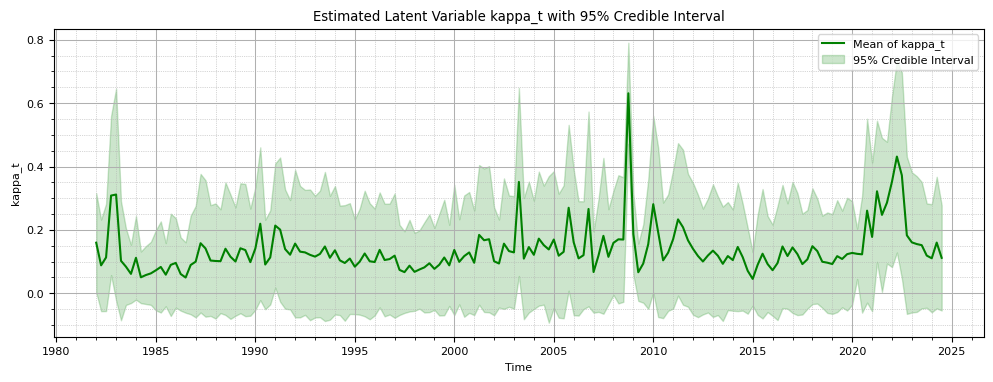

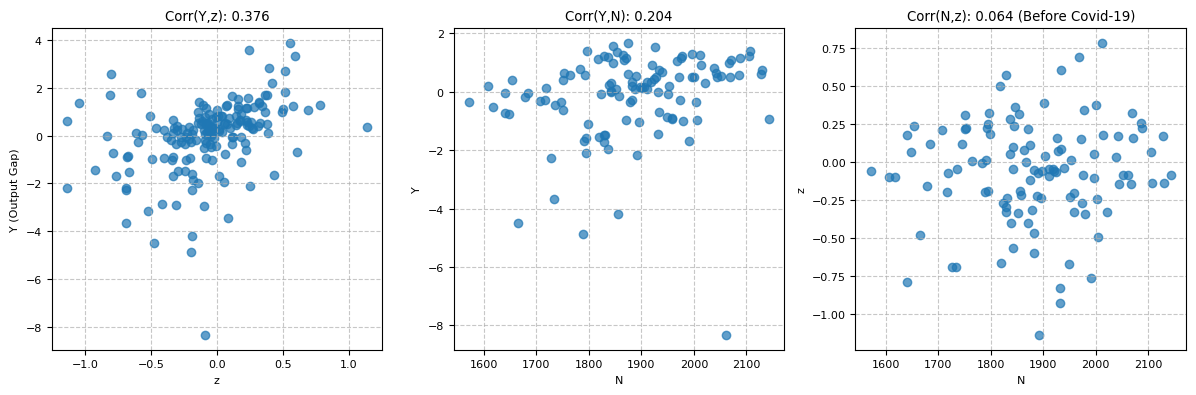

In [21]:
model_number = "29"
idata = globals()[f"idata_{model_number}"]
if "z" in idata.posterior.data_vars:
    z_mean_value =  globals()[f"z_mean_{model_number}"]
    z_lower =  globals()[f"z_lower_{model_number}"]
    z_upper =  globals()[f"z_upper_{model_number}"]
else:
    z_mean_value = np.zeros(len(data["DATE"]))
    z_lower =  np.zeros(len(data["DATE"]))
    z_upper =  np.zeros(len(data["DATE"]))

if "kappa" in idata.posterior.data_vars:
    kappa_mean_value =  globals()[f"kappa_mean_{model_number}"]
    kappa_lower =  globals()[f"kappa_lower_{model_number}"]
    kappa_upper =  globals()[f"kappa_upper_{model_number}"]
else:
    kappa_mean_value = np.zeros(len(data["DATE"]))
    kappa_lower =  np.zeros(len(data["DATE"]))
    kappa_upper =  np.zeros(len(data["DATE"]))
    
plt.rcParams.update({'font.size': 8}) 
df = data
df["z"] = z_mean_value
data_N = pd.read_csv("data/BLS-bd-BDS0000000000000000120001LQ5.csv")
data_N["N_end"] = data_N["National – Gross Job Gains – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120001LQ5)"]
data_N["N"] = data_N["N_end"].shift(1)
data_N['q'] = data_N["period"]
data_N["q"] = data_N["q"].str.replace(" ", "")
data_N["DATE"] = data_N["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_N = data_N[["DATE", "N"]]
df_merged = pd.merge(df, data_N, on="DATE", how="outer")
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged["DATE"]<'2020-09-01']

import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_value, label="Mean of z_t", color="blue")
plt.fill_between(data["DATE"], z_lower, z_upper, color="blue", alpha=0.2, label="95% Credible Interval")
plt.title("Estimated Latent Variable z_t with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

# print(f"Bayesian R^2: {r2}")
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], kappa_mean_value, label="Mean of kappa_t", color="green")
plt.fill_between(data["DATE"], kappa_lower, kappa_upper, color="green", alpha=0.2, label="95% Credible Interval")
plt.title("Estimated Latent Variable kappa_t with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("kappa_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
corrcoef1 = np.corrcoef(z_mean_value, data["Y"])[0, 1]
axes[0].scatter(z_mean_value, data["Y"], alpha=0.7)
axes[0].set_xlabel("z")
axes[0].set_ylabel("Y (Output Gap)")
axes[0].set_title(f"Corr(Y,z): {corrcoef1:.3f}")
axes[0].grid(True, linestyle='--', alpha=0.7)

corrcoef2 = np.corrcoef(df_merged["N"], df_merged["Y"])[0, 1]
axes[1].scatter(df_merged["N"], df_merged["Y"], alpha=0.7)
axes[1].set_xlabel("N")
axes[1].set_ylabel("Y")
axes[1].set_title(f"Corr(Y,N): {corrcoef2:.3f}")
axes[1].grid(True, linestyle='--', alpha=0.7)

corrcoef3 = np.corrcoef(df_merged["N"], df_merged["z"])[0, 1]
axes[2].scatter(df_merged["N"], df_merged["z"], alpha=0.7)
axes[2].set_xlabel("N")
axes[2].set_ylabel("z")
axes[2].set_title(f"Corr(N,z): {corrcoef3:.3f} (Before Covid-19)")
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    if "z" in available_params:
        z_samples = idata.posterior["z"].values 
        z_mean = z_samples.mean(axis=(0, 1))     
        corr1 = np.corrcoef(Y, z_mean)[0, 1]
        row["corr(Y,Z)"] = corr1
        df["z"] = z_mean
        df_merged = pd.merge(df, data_N, on="DATE", how="outer")
        df_merged = df_merged.dropna()
        df_merged = df_merged[df_merged["DATE"]<'2020-01-01']
        corr2 = np.corrcoef(df_merged["N"], df_merged["z"])[0, 1]
        row["corr(N,Z)"] = corr2
    else:
        row["corr(Y,Z)"] = "-"
        row["corr(N,Z)"] = "-"
    if "kappa" in available_params:
        kappa_samples = idata.posterior["kappa"].values 
        kappa_mean = kappa_samples.mean(axis=(0, 1))     
        df["kappa"] = kappa_mean
        df_merged = pd.merge(df, data_N, on="DATE", how="outer")
        df_merged = df_merged.dropna()
        df_merged = df_merged[df_merged["DATE"]<'2018-01-01']
        corr2 = np.corrcoef(df_merged["N"], df_merged["kappa"])[0, 1]
        row["corr(N,k)"] = corr2
    else:
        row["corr(N,k)"] = "-"
    df_list.append(row)
    
summary_df = pd.DataFrame(df_list)
summary_df

,model,"corr(Y,Z)","corr(N,Z)","corr(N,k)"
0,Model-0-0,-,-,NaN
1,Model-0-1,-,-,NaN
2,Model-1,0.158617,0.193783,NaN
3,Model-2,0.181914,0.217152,NaN
4,Model-3,0.270645,0.25612,NaN
5,Model-4,0.575546,0.457393,NaN
6,Model-5,0.29592,0.290198,NaN
7,Model-6,0.340362,0.320072,NaN
8,Model-7,0.281279,0.282302,NaN
9,Model-8,0.293308,0.282256,NaN
